In [2]:
# Install required packages
%pip install xgboost pandas numpy matplotlib seaborn scikit-learn

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [4]:
# Load dataset
df = pd.read_csv("../data.csv")

In [5]:
# Prepare features and labels
X = df.drop(columns=["y", "z", "schoolid"])
y = df["y"]
t = df["z"]
X = pd.get_dummies(X, drop_first=True)

In [6]:
# Split treated and control groups
X_treated = X[t == 1]
y_treated = y[t == 1]
X_control = X[t == 0]
y_control = y[t == 0]

In [7]:
# Random Forest models for T-learner
rf_treated = RandomForestRegressor(random_state=42)
rf_control = RandomForestRegressor(random_state=42)

rf_treated.fit(X_treated, y_treated)
rf_control.fit(X_control, y_control)

mu1_rf = rf_treated.predict(X)
mu0_rf = rf_control.predict(X)
ite_rf = mu1_rf - mu0_rf
ate_rf = np.mean(ite_rf)
print(f"ATE (T-Learner, Random Forest): {ate_rf:.4f}")

ATE (T-Learner, Random Forest): 0.4218


In [8]:
# XGBoost models for T-learner
xgb_treated = XGBRegressor(random_state=42, verbosity=0)
xgb_control = XGBRegressor(random_state=42, verbosity=0)

xgb_treated.fit(X_treated, y_treated)
xgb_control.fit(X_control, y_control)

mu1_xgb = xgb_treated.predict(X)
mu0_xgb = xgb_control.predict(X)
ite_xgb = mu1_xgb - mu0_xgb
ate_xgb = np.mean(ite_xgb)
print(f"ATE (T-Learner, XGBoost): {ate_xgb:.4f}")

ATE (T-Learner, XGBoost): 0.4219


In [9]:
# Bootstrap CI for T-Learner
def bootstrap_ci_tlearner(model_treated, model_control, X, n_boot=1000, alpha=0.05):
    n = len(X)
    ates = []
    for _ in range(n_boot):
        idx = np.random.choice(n, n, replace=True)
        mu1 = model_treated.predict(X.iloc[idx])
        mu0 = model_control.predict(X.iloc[idx])
        ates.append(np.mean(mu1 - mu0))
    lower = np.percentile(ates, 100 * alpha / 2)
    upper = np.percentile(ates, 100 * (1 - alpha / 2))
    return lower, upper

# Example usage:
ci_rf = bootstrap_ci_tlearner(rf_treated, rf_control, X)
ci_xgb = bootstrap_ci_tlearner(xgb_treated, xgb_control, X)

print(f"95% CI (T-Learner RF): [{ci_rf[0]:.4f}, {ci_rf[1]:.4f}]")
print(f"95% CI (T-Learner XGB): [{ci_xgb[0]:.4f}, {ci_xgb[1]:.4f}]")

95% CI (T-Learner RF): [0.4094, 0.4340]
95% CI (T-Learner XGB): [0.4100, 0.4336]


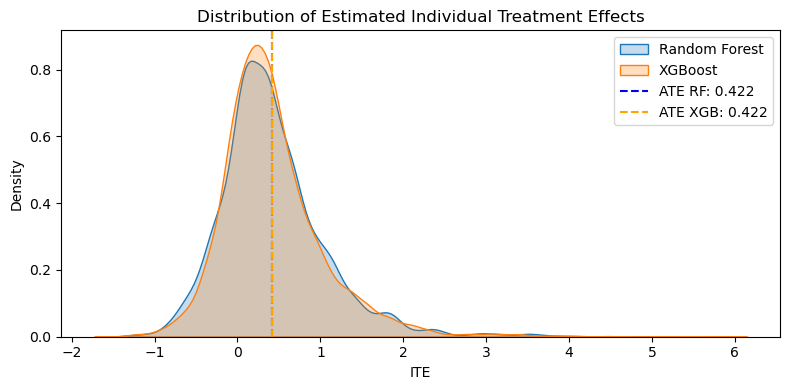

In [10]:
# Plot distribution of Individual Treatment Effects (ITE)
plt.figure(figsize=(8, 4))
sns.kdeplot(ite_rf, label="Random Forest", fill=True)
sns.kdeplot(ite_xgb, label="XGBoost", fill=True)
plt.axvline(ate_rf, color="blue", linestyle="--", label=f"ATE RF: {ate_rf:.3f}")
plt.axvline(ate_xgb, color="orange", linestyle="--", label=f"ATE XGB: {ate_xgb:.3f}")
plt.title("Distribution of Estimated Individual Treatment Effects")
plt.xlabel("ITE")
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Recalculate propensity scores if not already done
from sklearn.linear_model import LogisticRegression

X_ps = df.drop(columns=['y', 'z', 'schoolid'])
X_ps = pd.get_dummies(X_ps, drop_first=True)
t = df['z']

ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X_ps, t)
df['pscore'] = ps_model.predict_proba(X_ps)[:, 1]

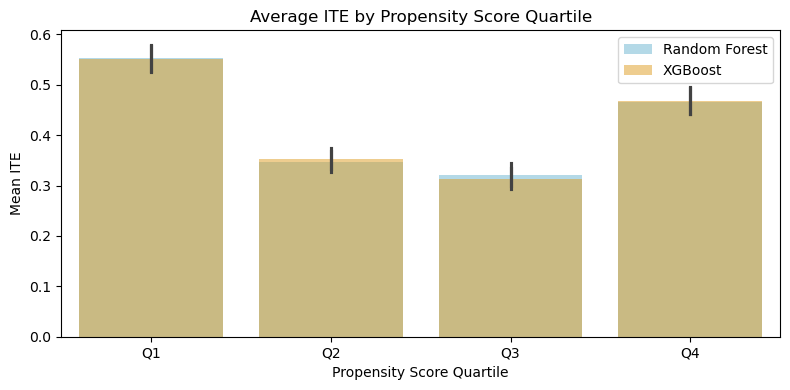

In [12]:
# Group data into quartiles based on propensity scores
df['pscore_bin'] = pd.qcut(df['pscore'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
df['ite_rf'] = ite_rf
df['ite_xgb'] = ite_xgb

# Bar plot showing mean ITE by propensity score quartile
plt.figure(figsize=(8, 4))
sns.barplot(data=df, x='pscore_bin', y='ite_rf', label='Random Forest', color='skyblue', alpha=0.7)
sns.barplot(data=df, x='pscore_bin', y='ite_xgb', label='XGBoost', color='orange', alpha=0.5)
plt.title("Average ITE by Propensity Score Quartile")
plt.xlabel("Propensity Score Quartile")
plt.ylabel("Mean ITE")
plt.legend()
plt.tight_layout()
plt.show()

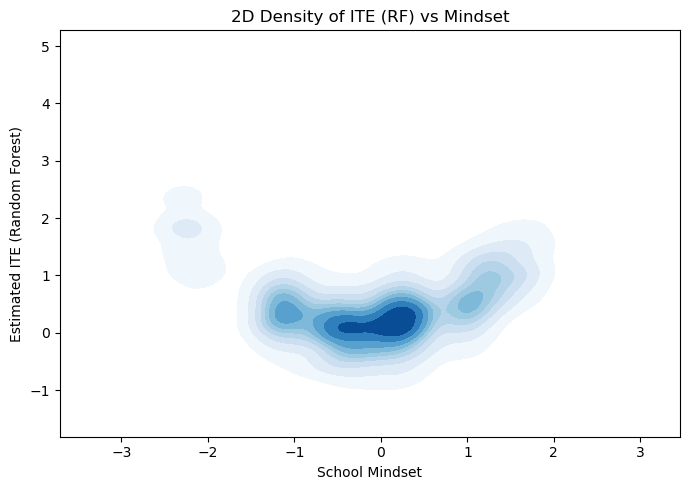

In [13]:
# 2D density plot: ITE vs mindset
plt.figure(figsize=(7, 5))
sns.kdeplot(x=df['mindset'], y=ite_rf, cmap="Blues", fill=True)
plt.title("2D Density of ITE (RF) vs Mindset")
plt.xlabel("School Mindset")
plt.ylabel("Estimated ITE (Random Forest)")
plt.tight_layout()
plt.show()